# Project

In [25]:
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_regress_exog

In [2]:
path = 'D:/OneDrive - University of Warwick/Dissertation/review-Alaska_10.json'

data_raw = pd.read_json(path, lines=True, encoding='utf-8')

c:\Python38\lib\site-packages\pandas\core\dtypes\cast.py:995: RuntimeWarning: invalid value encountered in cast
  return arr.astype(dtype, copy=True)


This indicates the presence of NA values in the data. However, as this is one of the aspects we intend to investigate, we will selectively perform data cleaning at a later stage.

In [3]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521515 entries, 0 to 521514
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  521515 non-null  float64
 1   name     521515 non-null  object 
 2   time     521515 non-null  int64  
 3   rating   521515 non-null  int64  
 4   text     298257 non-null  object 
 5   pics     20851 non-null   object 
 6   resp     44232 non-null   object 
 7   gmap_id  521515 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 31.8+ MB
None


In [4]:
print(data_raw.head())

        user_id               name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b77f:0xd8975e316de80952  
4  0x56b6

## Data Dictionary

- index: The index of the data.
- user_id: The ID of the reviewer.
- name: The name of the reviewer.
- time: The time of the review in Unix time format.
- rating: The rating given by the reviewer for the business.
- text: The text of the review.
- pics: Pictures associated with the review.
- resp: The business response to the review, including Unix time and the text of the response.
- gmap_id: The ID of the business.

Due to the nature of our research topic, which is to explore the influence of time of day on online ratings across different devices, we will be selecting specific data variables for further analysis. The data variables of interest include "time," "rating," and "pics." The reason for selecting "pics" is due to the unfortunate inability to obtain data directly related to device types in the comments. Therefore, we need to make a crucial assumption: 
**we assume that comments with pictures are uploaded using mobile devices, while comments without pictures are uploaded using non-mobile devices.**

## Data Preprocessing



In this section, we will perform data preprocessing, which includes data cleaning and data transformation. Data cleaning involves handling missing values, outliers, and inconsistencies in the dataset. Data transformation may involve converting the "pics" data into device type data, etc. These steps allow us to make use of the available information and derive meaningful insights from the dataset. 

In [5]:
data_modified = (
    data_raw
    .assign(time=lambda x: pd.to_datetime(x['time'], unit='ms').dt.hour)
    .assign(time=lambda x: pd.cut(x['time'], bins=[0, 8, 16, 24], labels=['Morning', 'Noon', 'Evening'], right=False))
    .assign(time=lambda x: pd.Categorical(x['time']))
    .assign(pics=lambda x: pd.Categorical(x['pics'].notnull().astype(int)))
    .filter(['time', 'rating', 'pics'])
)

print(data_modified[:10])


      time  rating pics
0  Evening       5    0
1  Morning       5    0
2  Morning       4    0
3  Evening       4    0
4  Morning       5    0
5     Noon       5    0
6  Morning       5    1
7  Morning       4    0
8  Morning       2    0
9  Evening       3    0


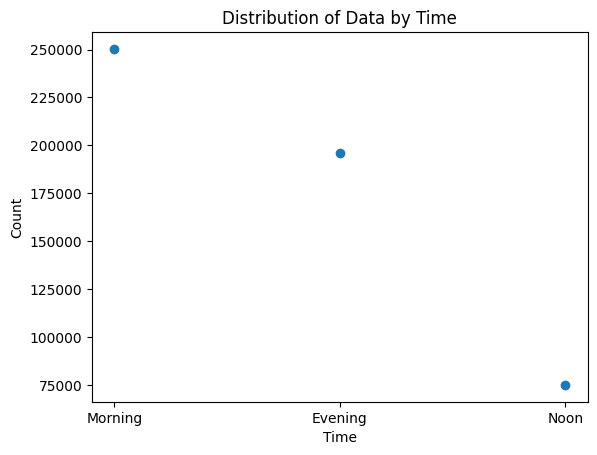

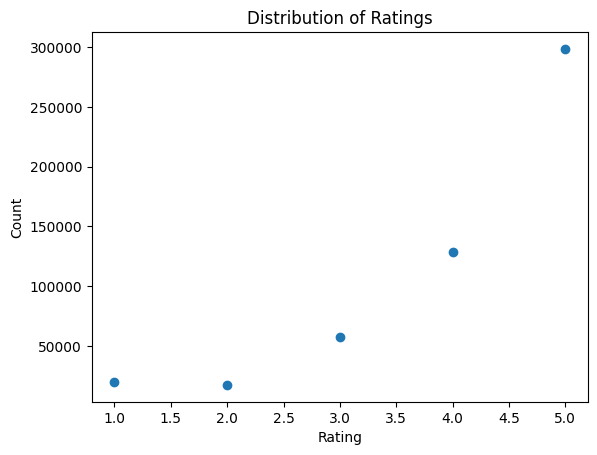

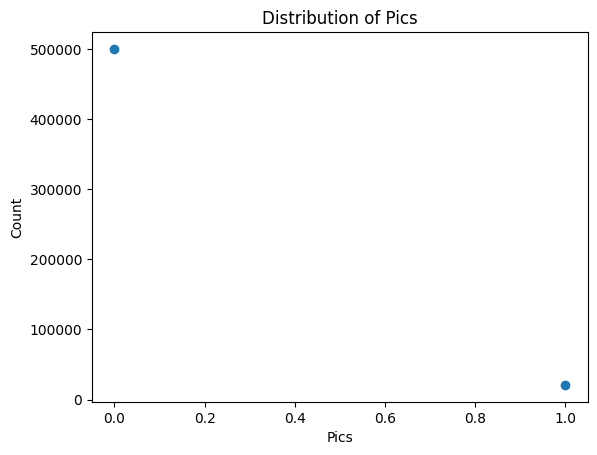

In [11]:
# Count of data by time
time_counts = data_modified['time'].value_counts()

# Scatter plot for data distribution by time
plt.scatter(time_counts.index, time_counts.values)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Data by Time')
plt.show()

# Count of data by rating
rating_counts = data_modified['rating'].value_counts()

# Scatter plot for rating distribution
plt.scatter(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

# Count of data by pics
pics_counts = data_modified['pics'].value_counts()

# Scatter plot for pics distribution
plt.scatter(pics_counts.index, pics_counts.values)
plt.xlabel('Pics')
plt.ylabel('Count')
plt.title('Distribution of Pics')
plt.show()


In [7]:
print(data_modified.isnull().sum())

time      0
rating    0
pics      0
dtype: int64


Overall, the data preprocessing step has been completed. There are no outliers, abnormal values and null values.

## Modeling

In [8]:
# data_modified['rating'] = pd.Categorical(data_modified['rating'], ordered=True)

### Data Balancing

According to the "rating distribution", it can be seen that there is a significant data imbalance between the different ratings, and stratified sampling may not be able to address this issue. Therefore, we plan to employ undersampling as a strategy to achieve balance in the dataset.

In [13]:
# Separate features (X) and target variable (y)
X = data_modified.drop('rating', axis=1)
y = data_modified['rating']

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new balanced dataframe
balanced_data = X_resampled.copy()
balanced_data['rating'] = y_resampled

# Check the balanced distribution of ratings
balanced_data['rating'].value_counts()


5    17239
4    17239
3    17239
2    17239
1    17239
Name: rating, dtype: int64

### Train and Test Sets

In [19]:
# # Separate features (X) and target variable (y) in the balanced dataset
# X = balanced_data.drop('rating', axis=1)
# y = balanced_data['rating']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2221877)

# # Print the shapes of the training and testing sets
# print("Training set shape:", X_train.shape, y_train.shape)
# print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (60336, 2) (60336,)
Testing set shape: (25859, 2) (25859,)


### Multiple Linear Regression

In [29]:
# Perform one-hot encoding for the 'time' column
time_encoded = pd.get_dummies(balanced_data['time'], prefix='time')

# Combine the encoded columns with the original DataFrame
data_encoded = pd.concat([balanced_data, time_encoded], axis=1)

# Convert 'pics' column to numeric
data_encoded['pics'] = pd.to_numeric(data_encoded['pics'])

# Define independent variables (X) and dependent variable (y)
X = data_encoded[['time_Morning', 'time_Noon', 'time_Evening', 'pics']]
y = data_encoded['rating']

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2221877)

# Fit the linear regression model
model = LinearRegression()
result = model.fit(X_train, y_train)
predictions = model.predict(X_test)

# model evaluation
print('mean_squared_error : ', mean_squared_error(y_test, predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))


mean_squared_error :  1.9823018283900753
mean_absolute_error :  1.1980563470265204


The mean squared error (MSE) of the model is 1.982, which indicates the average squared difference between the predicted ratings and the actual ratings. A lower MSE indicates better model performance.

The mean absolute error (MAE) of the model is 1.198, which represents the average absolute difference between the predicted ratings and the actual ratings. Like MSE, a lower MAE indicates better model performance.

Overall, these metrics suggest that the model has some level of accuracy in predicting the ratings, but further evaluation and comparison with alternative models would be beneficial to assess its performance more comprehensively.

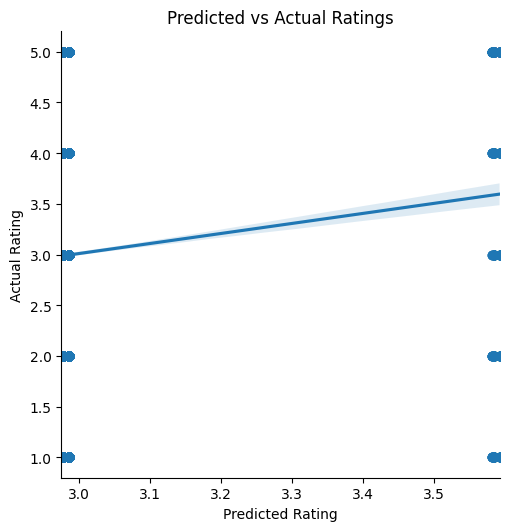

In [33]:
import seaborn as sns

# Merge predictions and y_test into a single data frame
plot_regression = pd.DataFrame({'predictions': predictions, 'actual_rating': y_test})

# Create a scatter plot with linear regression line
sns.lmplot(x="predictions", y="actual_rating", data=plot_regression, scatter_kws={"alpha": 0.5})
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.title('Predicted vs Actual Ratings')
plt.show()


### Two-way ANOVA

In [24]:
# Separate features (X) and target variable (y) in the balanced dataset
X = balanced_data.drop('rating', axis=1)
y = balanced_data['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2221877)

# Combine the features and target variable into a single DataFrame
data_train = X_train.copy()
data_train['rating'] = y_train

# Define the formula
formula = 'rating ~ C(time) + C(pics)'

# Fit the model on the training set
model = ols(formula, data=data_train).fit()

# Perform ANOVA analysis on the training set
anova_results = sm.stats.anova_lm(model)
print(anova_results)

               df         sum_sq     mean_sq           F        PR(>F)
C(time)       2.0       3.193741    1.596871    0.800888  4.489351e-01
C(pics)       1.0     594.824873  594.824873  298.325902  1.104611e-66
Residual  60332.0  120294.530163    1.993876         NaN           NaN


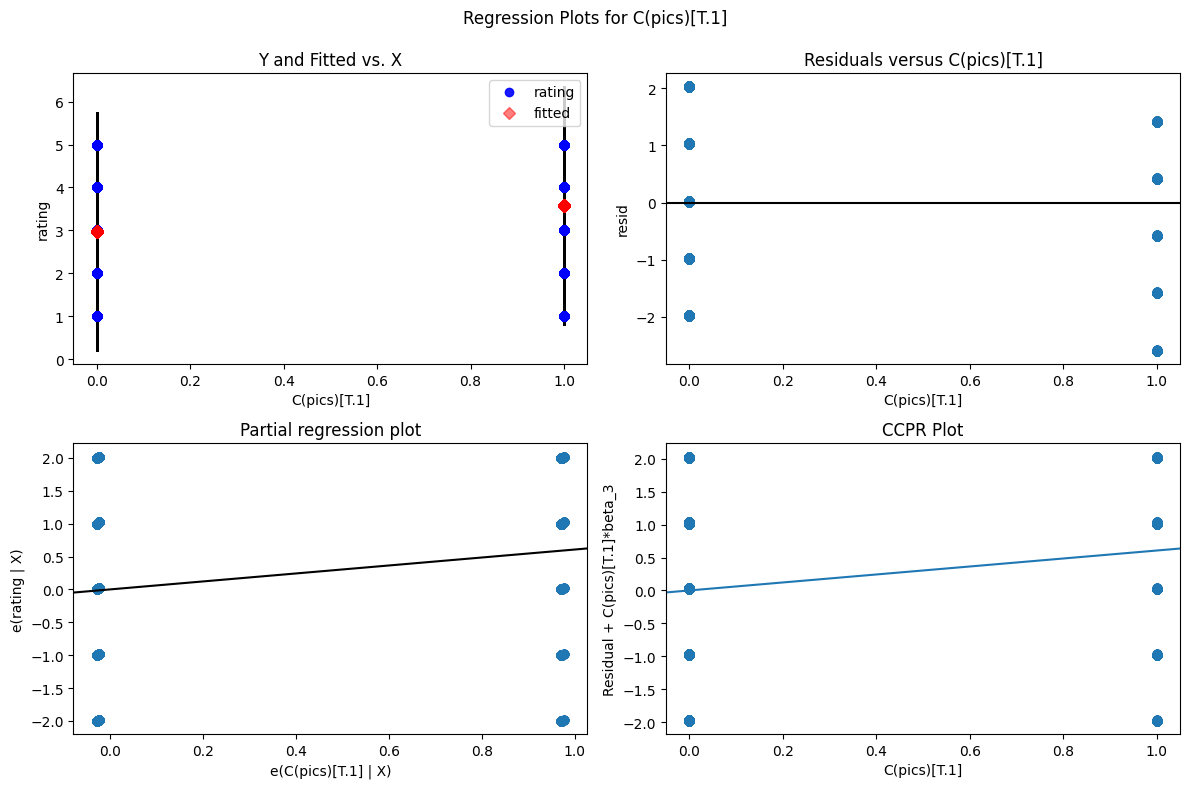

In [28]:
# Create the residual plot
fig = plt.figure(figsize=(12, 8))
plot_regress_exog(model, 'C(pics)[T.1]', fig=fig)

# Show the plot
plt.show()

Although the p-values of the two columns are very optimistic, the degrees of freedom of the residuals are too large.